In [1]:
import pandas as pd
import seaborn as sns
import sklearn
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

import mlflow
import os

The dataset is here: https://www.kaggle.com/datasets/nehaprabhavalkar/av-healthcare-analytics-ii


The aim of the dataset is to predict hospital length of stay - which is represented by the ``stay`` column. Interesting it is discretized into 11 different categories. 
The question is to treat as classification or as an ordinal regression task.....

In [2]:
df_dictionary = pd.read_csv('../data/train_data_dictionary.csv')

In [3]:
df_dictionary

,Column,Description
0,case_id,Case_ID registered in Hospital
1,Hospital_code,Unique code for the Hospital
2,Hospital_type_code,Unique code for the type of Hospital
3,City_Code_Hospital,City Code of the Hospital
4,Hospital_region_code,Region Code of the Hospital
5,Available Extra Rooms in Hospital,Number of Extra rooms available in the Hospital
6,Department,Department overlooking the case
7,Ward_Type,Code for the Ward type
8,Ward_Facility_Code,Code for the Ward Facility
9,Bed Grade,Condition of Bed in the Ward


In [4]:
df = pd.read_csv('../data/train_data.csv', index_col='case_id')
df

,Hospital_code,Hospital_type_code,City_Code_Hospital,Hospital_region_code,Available Extra Rooms in Hospital,Department,Ward_Type,Ward_Facility_Code,Bed Grade,patientid,City_Code_Patient,Type of Admission,Severity of Illness,Visitors with Patient,Age,Admission_Deposit,Stay
case_id,,,,,,,,,,,,,,,,,
1,8,c,3,Z,3,radiotherapy,R,F,2.0,31397,7.0,Emergency,Extreme,2,51-60,4911.0,0-10
2,2,c,5,Z,2,radiotherapy,S,F,2.0,31397,7.0,Trauma,Extreme,2,51-60,5954.0,41-50
3,10,e,1,X,2,anesthesia,S,E,2.0,31397,7.0,Trauma,Extreme,2,51-60,4745.0,31-40
4,26,b,2,Y,2,radiotherapy,R,D,2.0,31397,7.0,Trauma,Extreme,2,51-60,7272.0,41-50
5,26,b,2,Y,2,radiotherapy,S,D,2.0,31397,7.0,Trauma,Extreme,2,51-60,5558.0,41-50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
318434,6,a,6,X,3,radiotherapy,Q,F,4.0,86499,23.0,Emergency,Moderate,3,41-50,4144.0,11-20
318435,24,a,1,X,2,anesthesia,Q,E,4.0,325,8.0,Urgent,Moderate,4,81-90,6699.0,31-40
318436,7,a,4,X,3,gynecology,R,F,4.0,125235,10.0,Emergency,Minor,3,71-80,4235.0,11-20


In [5]:
df.describe()

,Hospital_code,City_Code_Hospital,Available Extra Rooms in Hospital,Bed Grade,patientid,City_Code_Patient,Visitors with Patient,Admission_Deposit
count,318438.000000,318438.000000,318438.000000,318325.000000,318438.000000,313906.000000,318438.000000,318438.000000
mean,18.318841,4.771717,3.197627,2.625807,65747.579472,7.251859,3.284099,4880.749392
std,8.633755,3.102535,1.168171,0.873146,37979.936440,4.745266,1.764061,1086.776254
min,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,0.000000,1800.000000
25%,11.000000,2.000000,2.000000,2.000000,32847.000000,4.000000,2.000000,4186.000000
50%,19.000000,5.000000,3.000000,3.000000,65724.500000,8.000000,3.000000,4741.000000
75%,26.000000,7.000000,4.000000,3.000000,98470.000000,8.000000,4.000000,5409.000000
max,32.000000,13.000000,24.000000,4.000000,131624.000000,38.000000,32.000000,11008.000000


In [6]:
# target colum
df.groupby('Stay')['Stay'].count()

Stay
0-10                  23604
11-20                 78139
21-30                 87491
31-40                 55159
41-50                 11743
51-60                 35018
61-70                  2744
71-80                 10254
81-90                  4838
91-100                 2765
More than 100 Days     6683
Name: Stay, dtype: int64

## Pre Processing

In [7]:
# Turning target column into a numeric option
df['Stay_numeric'] = df['Stay'].map(
{'0-10': 1,
'11-20': 2,
'21-30': 3,
'31-40': 4,
'41-50': 5,
'51-60': 6,
'61-70': 7,
'71-80': 8,
'81-90': 9,
'91-100': 10,
'More than 100 Days':11})

# Dichotomise into admitted for Longer then 30 days or not
df['long_stay'] = df['Stay_numeric']>3
df['long_stay'] = df['long_stay'].replace({True:1, False:0})


# Encode categorical variables and treat like ordinal
le = LabelEncoder()
columns_to_encode = [
    "Hospital_type_code",
    "Hospital_region_code",
    "Department",
    "Ward_Type",
    "Ward_Facility_Code",
    "Type of Admission",
    "Severity of Illness",
    "City_Code_Patient"
]

for column in columns_to_encode:
    # if column == "City_Code_Patient":
    #     df[column] = df[column].astype('int')
    # else:
        df[column] = le.fit_transform(df[column].values)

# If hosp and patient are in same city
df['hosp_patient_same'] = [1 if i == j else 0 for i, j in zip(df["City_Code_Hospital"].values, df['City_Code_Patient'].values)]

# Gender. 1 -> Female, 0 -> Male
df["Gender"] = [1 if i=="gynecology" else 0 for i in df["Department"].values]


# Number of hospitals in a city
df["Num_hospitals"] = df.groupby(["City_Code_Hospital"])["Hospital_code"].nunique()
df["Num_hospitals"] = df["Num_hospitals"].fillna(0)

# number of unique hospitals visited
df['unique_hospital_visited']=df.groupby('patientid')['Hospital_code'].transform('nunique')

class_map = {"0-10": 0, "11-20": 1, "21-30": 2, "31-40": 3, "41-50": 4, "51-60": 5, "61-70": 6, "71-80": 7, "81-90": 8, "91-100": 9, "More than 100 Days": 10}
#class_map_rev = {0: "0-10", 1: "11-20", 2: "21-30", 3: "31-40", 4: "41-50", 5: "51-60", 6: "61-70", 7: "71-80", 8: "81-90", 9: "91-100", 10: "More than 100 Days"}

df["Age"] = [(class_map[i]*10)+1 for i in df["Age"].values]


# drop any left over na's
df = df.dropna()


# Remove unneeded columns
df = df.drop(['Stay'], axis=1)

In [8]:
# Test train split
y = df['long_stay']
X = df.drop(['long_stay',  'Stay_numeric'], axis=1)

# split into test and train
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)

## EDA

<Axes: >

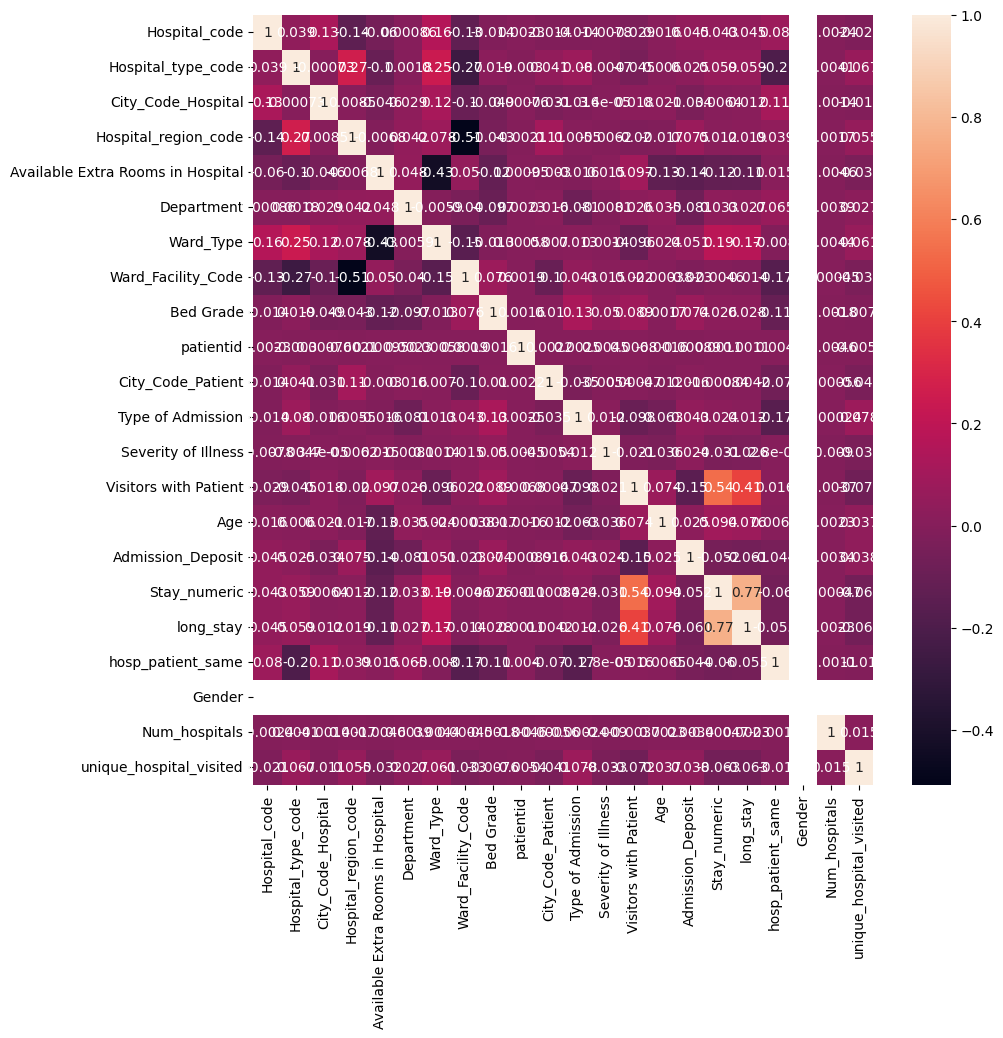

In [9]:
# Calculate correlation matrix
corr_matrix = df.corr()
plt.figure(figsize=(10,10))
sns.heatmap(corr_matrix,annot=True)


In [10]:
def train_test_model(model, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test):
    model = model

    # Fit the model to the training data
    model.fit(X_train, y_train)

    # Predict the target variable for the test set
    y_pred = model.predict(X_test)

    # Create and print the confusion matrix
    cm = confusion_matrix(y_test, y_pred, normalize='true')
    print("Normalized Confusion Matrix:")
    print(cm)

    # Calculate and print the accuracy score
    accuracy = accuracy_score(y_test, y_pred)
    print("Accuracy:", accuracy)

    # Calculate the predicted probabilities and AUC score
    y_prob = model.predict_proba(X_test)[:, 1]
    auc_score = roc_auc_score(y_test, y_prob)
    print("AUC Score:", auc_score)
    
    return model

## ML Modelling

In [11]:
model = LogisticRegression()

# Fit the model to the training data
model.fit(X_train, y_train)

# Predict the target variable for the test set
# Predict the target variable for the test set
y_pred = model.predict(X_test)

# Create and print the confusion matrix
cm = confusion_matrix(y_test, y_pred, normalize='true')
print("Normalized Confusion Matrix:")
print(cm)

# Calculate and print the accuracy score
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Calculate the predicted probabilities and AUC score
y_prob = model.predict_proba(X_test)[:, 1]
auc_score = roc_auc_score(y_test, y_prob)
print("AUC Score:", auc_score)

Normalized Confusion Matrix:
[[0.85742967 0.14257033]
 [0.43831848 0.56168152]]
Accuracy: 0.7375323961360245
AUC Score: 0.7558135211896411


In [12]:
model = LogisticRegression()
train_test_model(model)

Normalized Confusion Matrix:
[[0.85742967 0.14257033]
 [0.43831848 0.56168152]]
Accuracy: 0.7375323961360245
AUC Score: 0.7558135211896411


LogisticRegression()

In [13]:
model = RandomForestClassifier()
train_test_model(model)

Normalized Confusion Matrix:
[[0.92743363 0.07256637]
 [0.39438202 0.60561798]]
Accuracy: 0.7969685070289798
AUC Score: 0.8335730453757892


RandomForestClassifier()

In [14]:
model = XGBClassifier()
train_test_model(model)


Normalized Confusion Matrix:
[[0.93398494 0.06601506]
 [0.40023247 0.59976753]]
Accuracy: 0.7984921071232232
AUC Score: 0.8433926029762111


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

## Wrap our model training into a mlflow workflow

In [19]:
def train_test_model(model, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test):
       
       tracking_uri = "../mlflow_models/"
       mlflow.set_tracking_uri(tracking_uri)
       with mlflow.start_run():
              mlflow.log_param("model_name", type(model).__name__)
              model = model

              # Fit the model to the training data
              model.fit(X_train, y_train)

              # Predict the target variable for the test set
              y_pred = model.predict(X_test)

              # Create and print the confusion matrix
              cm = confusion_matrix(y_test, y_pred, normalize='true')
              print("Normalized Confusion Matrix:")
              print(cm)

              # Calculate and print the accuracy score
              accuracy = accuracy_score(y_test, y_pred)
              mlflow.log_metric("accuracy", accuracy)
              print("Accuracy:", accuracy)

              # Calculate the predicted probabilities and AUC score
              y_prob = model.predict_proba(X_test)[:, 1]
              auc_score = roc_auc_score(y_test, y_prob)
              mlflow.log_metric("auc_score", auc_score)
              print("AUC Score:", auc_score)

              # Save the model as an artifact
              mlflow.sklearn.log_model(model, "model")
       return model

models = [LogisticRegression(), RandomForestClassifier(), XGBClassifier()]

for model in models:
       train_test_model(model)

Normalized Confusion Matrix:
[[0.85742967 0.14257033]
 [0.43831848 0.56168152]]
Accuracy: 0.7375323961360245
AUC Score: 0.7558135211896411
Normalized Confusion Matrix:
[[0.92672038 0.07327962]
 [0.39290972 0.60709028]]
Accuracy: 0.7971412864211105
AUC Score: 0.8340798043023012
Normalized Confusion Matrix:
[[0.93398494 0.06601506]
 [0.40023247 0.59976753]]
Accuracy: 0.7984921071232232
AUC Score: 0.8433926029762111


### Find, return and load the serialized best model for use

In [16]:
def best_model():
    # search mlflow for best model
    runs = mlflow.search_runs()
    # find te best run by auc score
    best_run = runs.loc[runs['metrics.auc_score'].idxmax()]
    #return the uri
    artifact_uri = best_run['artifact_uri']

    # Load the model using the artifact URI
    model = mlflow.sklearn.load_model(artifact_uri + "/model")

    return model

In [17]:
model.predict(X_test)

array([0, 0, 0, ..., 1, 0, 0])

In [18]:
model

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)